In [1]:
import pandas as pd
import numpy as npz
import scipy
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
os.environ["OMP_NUM_THREADS"] = "1"

### REPO: https://github.com/deri9377/masters/tree/main/Deep_Learning_Final

## The Problem
The problem is to classify vehicles based on the audio sound they produce. This will be possible by using Deep learnning methods. I felt this would be an interesting problem to solve and could be usefull if you wanted to figure out what kind of vehicle you are hearing. For example, if you were watching a video or in real life if a car was nearby and you did not know what kind of car it was. You could use the classifier to figure it out. I also would like to encopurate some sort of generator model into this project. Similar to what was done in week 5.

## Initial Plan

My initial plan is to look for datasets on the internet, probably kaggle. To see if anyone has gathered audio clips of different vehicles. I would be looking for the following datasets. Either a dataset that has different kinds of vehicles. Like cars, motorcycles, dirt bikes, trains, airplanes, etc. Or I would be looking for a dataset that provide specific cars like bmw, mercedies, toyota, etc. And if possible It would be great to find a dataset that has the exact make and model of the car so that I can go in and map the engine specs onto the car dataset itself. If I can't find the data I probably will have to think of another more broad sound classification problem since I think gathering all of that data myself would be quite time consuming and would not be focused on what we had learned in this class.

## The Data
Here is a list of potential datasets that can be used
Vehicle Sounds Dataset - https://www.kaggle.com/datasets/janboubiabderrahim/vehicle-sounds-dataset
- Car, Truck, Bus, Train, Bicycle, Motorcycle, Airplane, Helicopter - format .wav file

Vehicle Type Sound Dataset - https://www.kaggle.com/datasets/brinkor/vehicle-type-sound-dataset
- class: 0 car, 1 truck bus van, 2 motorcycle -- format csv and .wav

Car: 230 audio \
Truck: 265 audio \
Bus: 4221 audio \
Train: 2552 audio \
Bicycle: 617 audio \
Motorcycle: 537 audio \
Airplane: 673 audio \
Helicopter: 353 audio 

going to cap the number of files to be the same as car which is 230

## Pre-processing

The data comes in the form a .wav file. Each of these files needs to be converted into frequency and magnitudes using a fft or fast forie transform.
This can be done using scipy.fft package. The result of an fft is the deconstructed frequency's that appear in the sound file. Another key part of the data that needs to be extracted are the magnitudes of the frequencies. This way we can construct a 2 dimensional map of the data.

For the first model the data will be used just to predict based on frequency which will be deep learning model that only uses 1D arrays.

The second model that I created used both frequency and magnitues to generate a 2d array and use Conv2D layers to generate a more accurate map

The third model that I created used a different structure entirely. I read the data into spec files which is a vizualization of the sound file. I then used the images that were generated to create predictions using another 2d deep learning model.

In [ ]:
import numpy as np
from scipy.io.wavfile import read
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

file_num_cap = 230
duration_limit_sec = 3
df = pd.DataFrame()
# Load a .wav file
path = "Devin_Riess_Deep_Learning_Final\\Data"
for subdir in os.listdir(path):
    results = []
    for file in os.listdir(os.path.join(path, subdir)):
        if len(results) < file_num_cap: 
            # Load the audio file
            sample_rate, audio_data = read(os.path.join(path,subdir,file))
            

            num_samples = duration_limit_sec * sample_rate
            audio_data = audio_data[:num_samples]
            # Compute the FFT of the audio data
            fft_output = fft(audio_data)
            
            # Get the frequency domain representation
            freqs = np.fft.fftfreq(len(audio_data), d=1/sample_rate)
            amplitudes = np.abs(fft_output)

            results.append({
                'Frequency': freqs,
                'Amplitude': amplitudes,
                'Label': subdir
            })
        
    df = pd.concat([df,pd.DataFrame(results)], axis=0)


# Example: plot the first sample
sample_idx = 0

# Extract frequency list (flatten if needed)
freqs = df.loc[sample_idx, 'Frequency']
# If it's a list of lists, flatten it
if isinstance(freqs[0], (list, np.ndarray)):
    freqs = [item for sublist in freqs for item in sublist]

# Extract amplitude list (flatten or choose one dimension)
amps = df.loc[sample_idx, 'Amplitude']

# If amplitude is nested (list of lists), flatten or pick a dimension
# For example, if amps are pairs [value1, value2], pick first value
if isinstance(amps[0], (list, np.ndarray)):
    amps = [a[0] for a in amps]

plt.figure(figsize=(12, 5))
plt.plot(freqs, amps)
plt.title(f"Frequency vs Amplitude - Label: {df.loc[sample_idx, 'Label']}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

C:\Users\devin\AppData\Local\Temp\ipykernel_15320\656796108.py:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = read(os.path.join(path,subdir,file))
C:\Users\devin\AppData\Local\Temp\ipykernel_15320\656796108.py:15: WavFileWarning: Incomplete chunk ID: b'\x00\x00', ignoring it.
  sample_rate, audio_data = read(os.path.join(path,subdir,file))


                                             Frequency  \
0    [0.0, 0.3333333333333333, 0.6666666666666666, ...   
1    [0.0, 0.3333333333333333, 0.6666666666666666, ...   
2    [0.0, 0.3333333333333333, 0.6666666666666666, ...   
3    [0.0, 0.3333333333333333, 0.6666666666666666, ...   
4    [0.0, 0.3333333333333333, 0.6666666666666666, ...   
..                                                 ...   
225  [0.0, 0.3333333333333333, 0.6666666666666666, ...   
226  [0.0, 0.3333333333333333, 0.6666666666666666, ...   
227  [0.0, 0.3333333333333333, 0.6666666666666666, ...   
228  [0.0, 0.3333333333333333, 0.6666666666666666, ...   
229  [0.0, 0.3333333333333333, 0.6666666666666666, ...   

                                             Amplitude     Label  
0    [[340.0, 4.0], [254.0, 2.0], [772.0, 0.0], [11...  Airplane  
1    [[5759.0, 5.0], [5976.0, 2.0], [6007.0, 5.0], ...  Airplane  
2    [[9598.0, 0.0], [2378.0, 0.0], [13440.0, 0.0],...  Airplane  
3    [[9182.0, 0.0], [9066.0, 0.0],

## Training

First Pass:
For the first pass I have decided to create a simpler version of this prediction model. We will just be using the frequencies and a 1d input to create a predictor. We take the data and extract just the Frequency column. We also use a LabelEncoder to encode the 8 different classes.

Second Pass:
we will be adding in a second dimension by imputting the amplitudes as well. We need to manipulate the data by concatinating the smplitudes with the frequency into a single input shape. This was tricky. Getting them to be the same length in order to concatenate when frequency had nx1 arrays and amplitude has nx2 arrays. That is because we need them to be the same shape. So if you reshape the amplitudes it cut the size in half after finding the min_len. I ended up fitting the amplitude to the min_len * 2 and then reshaped it to 2d

In [34]:
num_classes_frequency = 8
le = LabelEncoder()
X = df.drop("Label", axis=1)
y = df['Label']
y = le.fit_transform(y)
# convert to tenso
min_len = min(
    min(len(f) for f in X['Frequency']),
    min(len(a) for a in X['Amplitude'])
)

print(min(len(a) for a in X['Amplitude']))

mask = X.apply(lambda row: len(row['Frequency']) >= min_len and len(row['Amplitude']) >= min_len, axis=1)
X = X[mask].reset_index(drop=True)
y = y[mask]

X['Frequency'] = X['Frequency'].apply(lambda x: np.array(x).reshape(-1,1))
X['Amplitude'] = X['Amplitude'].apply(lambda x: np.array(x).reshape(-1,2))

print(X)

X['Frequency'] = X['Frequency'].apply(lambda x: x[:66150])
X['Amplitude'] = X['Amplitude'].apply(lambda x: x[:66150])

print(min_len, X['Frequency'].iloc[0], X['Amplitude'].iloc[0])

X['FreqAmp'] = X.apply(
    lambda row: np.concatenate([row['Frequency'], row['Amplitude']], axis=1),
    axis=1
)


132214
                                              Frequency  \
0     [[0.0], [0.3333333333333333], [0.6666666666666...   
1     [[0.0], [0.3333333333333333], [0.6666666666666...   
2     [[0.0], [0.3333333333333333], [0.6666666666666...   
3     [[0.0], [0.3333333333333333], [0.6666666666666...   
4     [[0.0], [0.3333333333333333], [0.6666666666666...   
...                                                 ...   
1835  [[0.0], [0.3333333333333333], [0.6666666666666...   
1836  [[0.0], [0.3333333333333333], [0.6666666666666...   
1837  [[0.0], [0.3333333333333333], [0.6666666666666...   
1838  [[0.0], [0.3333333333333333], [0.6666666666666...   
1839  [[0.0], [0.3333333333333333], [0.6666666666666...   

                                              Amplitude  
0     [[340.0, 4.0], [254.0, 2.0], [772.0, 0.0], [11...  
1     [[5759.0, 5.0], [5976.0, 2.0], [6007.0, 5.0], ...  
2     [[9598.0, 0.0], [2378.0, 0.0], [13440.0, 0.0],...  
3     [[9182.0, 0.0], [9066.0, 0.0], [8328.0, 0.0], 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from keras.utils import to_categorical

# Assuming y_train and y_test are class indices (e.g., 0 to 7)
y_train = to_categorical(y_train, num_classes=num_classes_frequency)
y_test = to_categorical(y_test, num_classes=num_classes_frequency)

X_train_seq = np.stack(X_train['FreqAmp'].values)
X_test_seq = np.stack(X_test['FreqAmp'].values)

## Architecture

First Pass:
As said before on the first pass we will be using just the frequency. Since this is the case the input will be a single dimension and we can only use Dense layers to reduce it to a softmax output. We use softmax since it is not a binary classification problem but a 8 classification problem.

Second Pass:
We will be using Conv2D layers now that we have a dataset that includes both frequency and amplitudes. This data has been concatinated and stacked into data in the shape (n_samples, 3)

In [36]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, Dense, Input
from keras import layers

model = Sequential()
model.add(Input(shape=(66150, 3)))
model.add(Conv1D(32, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes_frequency, activation='softmax'))

In [37]:
from keras.optimizers import Adam
# Compile the CNN model
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model on the training data
history = model.fit(X_train_seq, y_train, epochs=5, batch_size=32, validation_data=(X_test_seq, y_test))

Epoch 1/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.1735 - loss: 785132.6875 - val_accuracy: 0.2391 - val_loss: 449.3760
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.3726 - loss: 237.1442 - val_accuracy: 0.4538 - val_loss: 174.0831
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7353 - loss: 30.9791 - val_accuracy: 0.4239 - val_loss: 151.5041
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8524 - loss: 8.4982 - val_accuracy: 0.4511 - val_loss: 151.2057
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9025 - loss: 3.4610 - val_accuracy: 0.4783 - val_loss: 139.6453


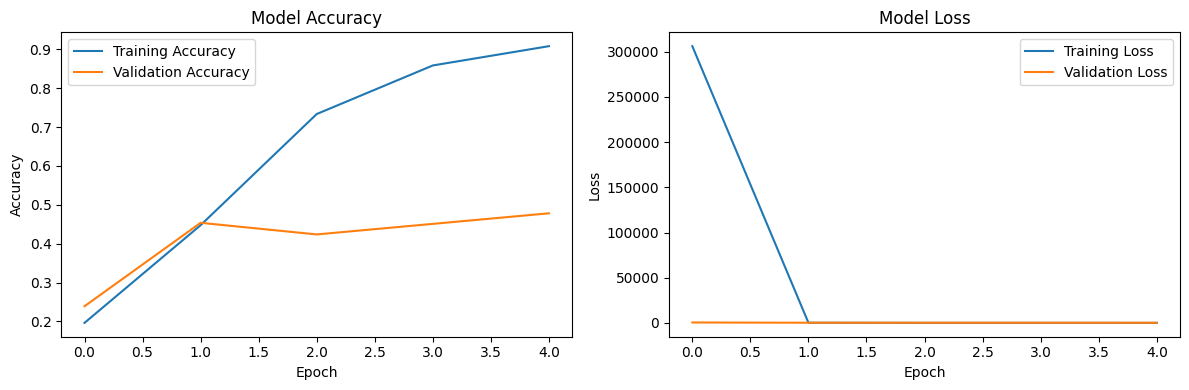

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## New approach using spectrograms images

I shifted gears here a bit and looked at what would happen if I instead used spectrograms instead of fft's to train my classifiers. This ended up requiring a different data pre processing and model training.

In [39]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras

base_data_path = "Devin_Riess_Deep_Learning_Final\\Data" 

# Parameters for Mel spectrograms
SR = 22050          # Standard sample rate for audio (samples per second)
N_FFT = 2048        # Number of samples per FFT window
HOP_LENGTH = 512    # Number of samples between successive frames
N_MELS = 128        # Number of Mel bands to generate (height of the spectrogram image)
DURATION_SEC = 3    # Target duration for each audio clip (in seconds)
MAX_AUDIO_SAMPLES = SR * DURATION_SEC # Max number of samples per audio clip
FILE_NUM_CAP = 230  # Cap the number of files per class sicne that is the cap for one of the classes

# --- Data Ingestion and Mel Spectrogram Creation ---
all_spectrograms = []
all_labels = []

# Get the list of subdirectories (which are your class labels)
class_labels = sorted([d for d in os.listdir(base_data_path) if os.path.isdir(os.path.join(base_data_path, d))])

print(f"Found {len(class_labels)} classes: {class_labels}")

for label in class_labels:
    class_path = os.path.join(base_data_path, label)
    audio_files = [f for f in os.listdir(class_path) if f.endswith('.wav')]
    print(f"Processing {len(audio_files)} files for class: {label}")

    count = 0
    for audio_file in audio_files:
        if count >= FILE_NUM_CAP:
            break # Cap the number of files per class

        file_path = os.path.join(class_path, audio_file)
        
        try:
            y, sr = librosa.load(file_path, sr=SR, duration=DURATION_SEC) 

            if len(y) < MAX_AUDIO_SAMPLES:
                y = np.pad(y, (0, MAX_AUDIO_SAMPLES - len(y)), 'constant')
            elif len(y) > MAX_AUDIO_SAMPLES:
                y = y[:MAX_AUDIO_SAMPLES]

            if len(y) != MAX_AUDIO_SAMPLES:
                 print(f"Warning: Audio for {audio_file} has unexpected length {len(y)}. Expected {MAX_AUDIO_SAMPLES}.")
                 continue 

            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            target_frames = int(np.ceil(MAX_AUDIO_SAMPLES / HOP_LENGTH))
            
            if mel_spec_db.shape[1] < target_frames:
                pad_width = target_frames - mel_spec_db.shape[1]
                mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant', constant_values=np.min(mel_spec_db))
            elif mel_spec_db.shape[1] > target_frames:
                mel_spec_db = mel_spec_db[:, :target_frames]
            mel_spec_db = mel_spec_db[..., np.newaxis]

            all_spectrograms.append(mel_spec_db)
            all_labels.append(label)
            count += 1

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue

print(f"\nFinished processing. Total spectrograms: {len(all_spectrograms)}")
print(f"Example spectrogram shape: {all_spectrograms[0].shape if all_spectrograms else 'N/A'}")



Found 8 classes: ['Airplane', 'Bics', 'Cars', 'Helicopter', 'Motocycles', 'Train', 'Truck', 'bus']
Processing 673 files for class: Airplane
Processing 617 files for class: Bics
Processing 230 files for class: Cars
Processing 353 files for class: Helicopter
Processing 537 files for class: Motocycles
Processing 2552 files for class: Train
Processing 265 files for class: Truck
Processing 4221 files for class: bus

Finished processing. Total spectrograms: 1840
Example spectrogram shape: (128, 130, 1)


## Vizualization of the data

as can be seen below the visualization of the data is not all that helpful. Most of the images are hard to tell the difference even with the classification labels present. The data is kind of all the same blobs. There are some patters over time here and there but not much.

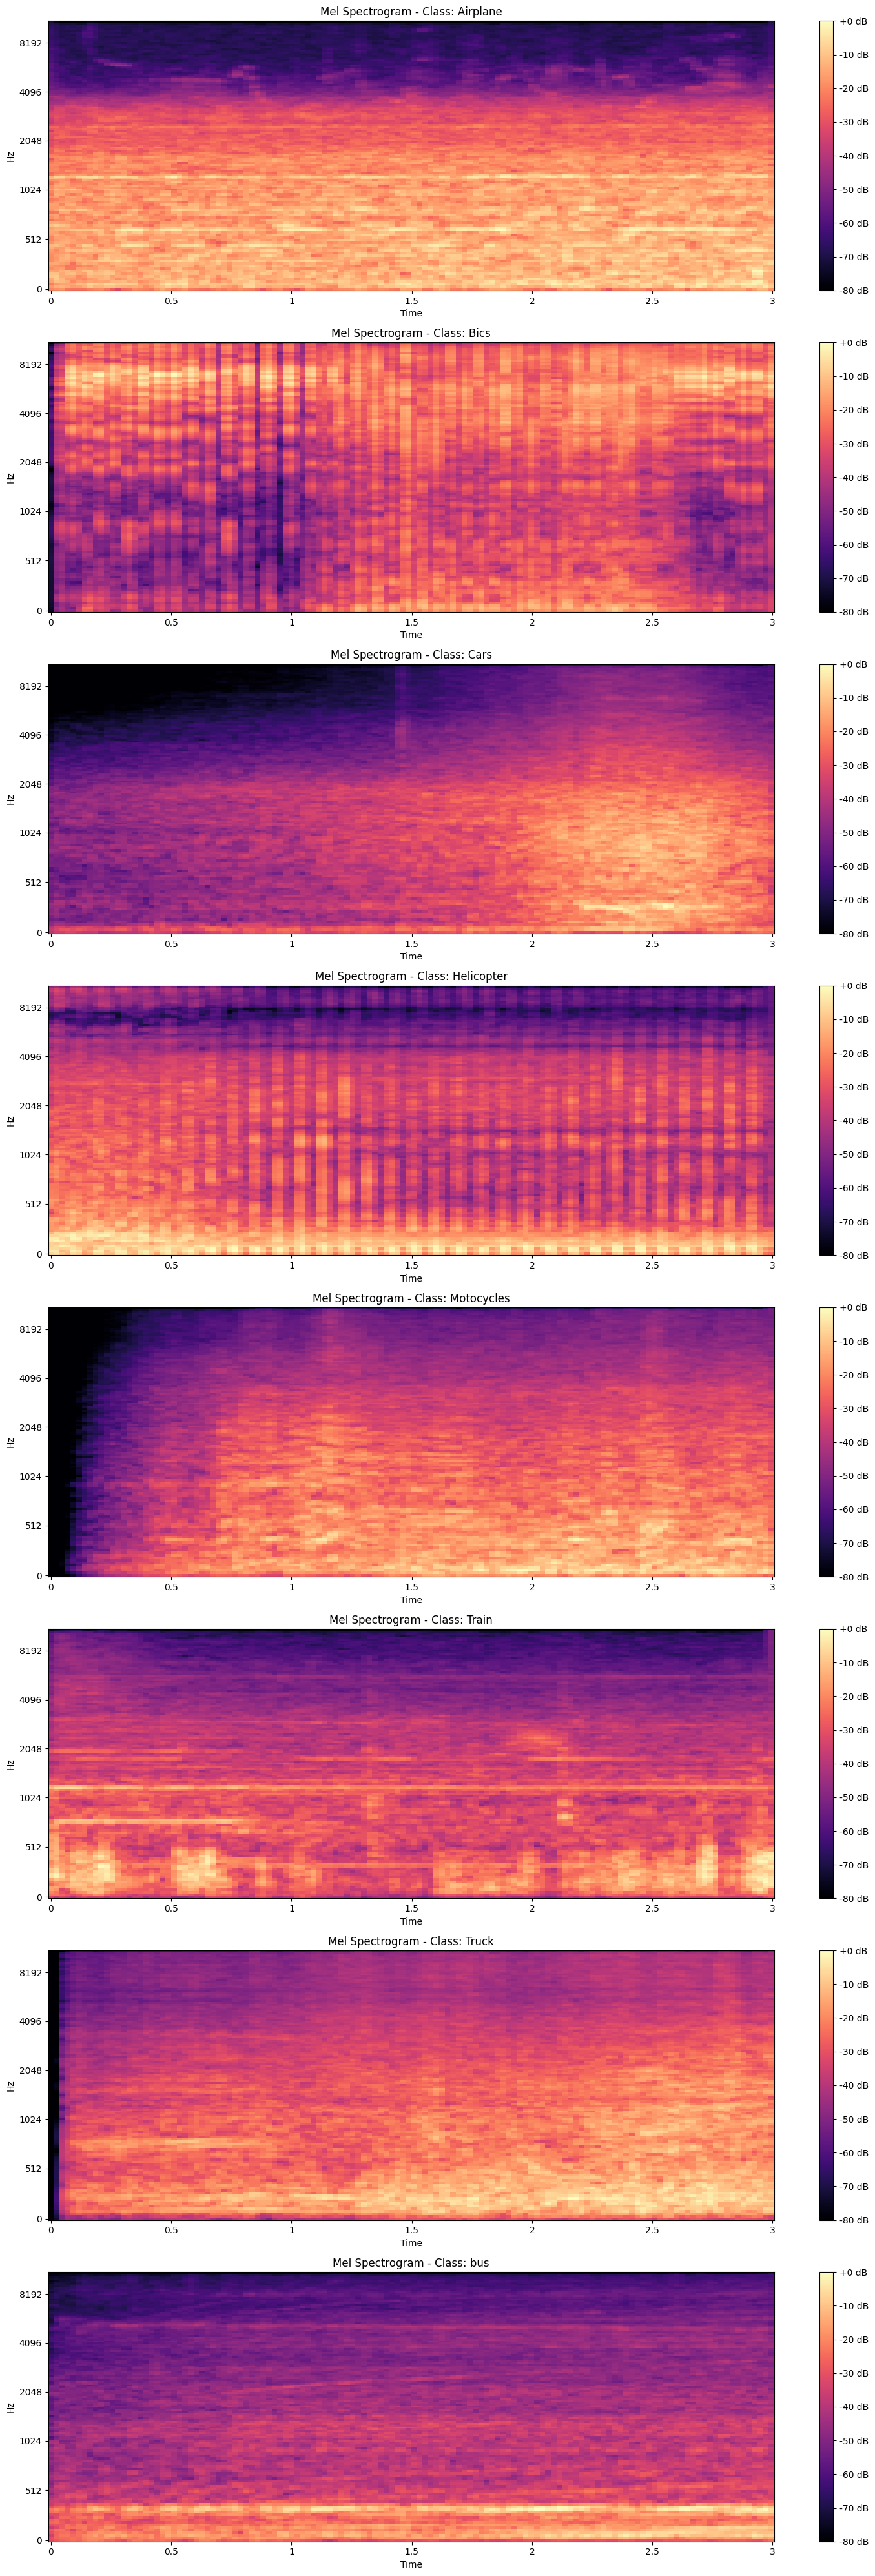

In [98]:
# --- Display One Spectrogram per Vehicle Type (Class) ---

import matplotlib.pyplot as plt

if all_spectrograms:
    shown_classes = set()
    plt.figure(figsize=(15, 5 * len(class_labels)))

    for i, (spec, label) in enumerate(zip(all_spectrograms, all_labels)):
        if label not in shown_classes:
            shown_classes.add(label)
            spec = spec.squeeze()  # Remove channel dimension
            plt_idx = len(shown_classes)

            plt.subplot(len(class_labels), 1, plt_idx)
            librosa.display.specshow(spec, sr=SR, hop_length=HOP_LENGTH, 
                                      x_axis='time', y_axis='mel', cmap='magma')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Mel Spectrogram - Class: {label}')

    plt.tight_layout()
    plt.show()
else:
    print("No spectrograms to display.")


## Pre processing

Nothing fancy going on here we are just taking the spectrograms and splitting them into test and train data. One thing to note is that I limited all of the files to be 3 seconds. I thought this would be helpful for input shapes of the models in general.

In [40]:
X = np.array(all_spectrograms)
y = np.array(all_labels)

X_scaled = (X - np.min(X)) / (np.max(X) - np.min(X))

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
y_one_hot = tf.keras.utils.to_categorical(y_encoded, num_classes=num_classes)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_one_hot, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Number of classes: {num_classes}")


Shape of X_train: (1472, 128, 130, 1)
Shape of y_train: (1472, 8)
Number of classes: 8


## Architecture 

We are using keras sequential models here to create or deep learning model. We use the standard array of Conv2D, BatchNormalization, and Pooling to create the model. We then use the 8 classes and a softmax to get our output layer. Also our input layer is simply the shape of the X data

For training I used a batch size of 32 and 20 epochs which is in the standard range. I normally like less epochs and higher batch sizes to increase the speed of the training. Learning rate is 0.001 which is also standard.

In [41]:

input_shape = X_train.shape[1:]

model = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Conv2D(32, kernel_size=(2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.summary()

# Compile the model
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train the Model ---
print("\nStarting model training...")
history = model.fit(
    X_train, y_train,
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test, y_test),
    verbose=1
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 130, 32)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 130, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 65, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 65, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 65, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,433,128 (32.17 MB)

 Trainable params: 8,432,680 (32.17 MB)

 Non-trainable params: 448 (1.75 KB)


Starting model training...
Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 358ms/step - accuracy: 0.3719 - loss: 11.9909 - val_accuracy: 0.1250 - val_loss: 12.5619
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 358ms/step - accuracy: 0.4845 - loss: 1.5233 - val_accuracy: 0.1250 - val_loss: 20.9429
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 355ms/step - accuracy: 0.5504 - loss: 1.2347 - val_accuracy: 0.1250 - val_loss: 29.4205
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 355ms/step - accuracy: 0.6350 - loss: 1.1241 - val_accuracy: 0.1250 - val_loss: 34.4361
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 352ms/step - accuracy: 0.6576 - loss: 0.9891 - val_accuracy: 0.1603 - val_loss: 30.3544
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 351ms/step - accuracy: 0.6435 - loss: 0.9404 - val_accuracy: 0.2418 - val_loss: 30.9844
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 352ms/step - accuracy: 0.6888 - loss: 0.8890 - val_accuracy: 0.1250 - val_loss: 38.7291
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step - accura


Test Loss: 0.4684
Test Accuracy: 0.8750


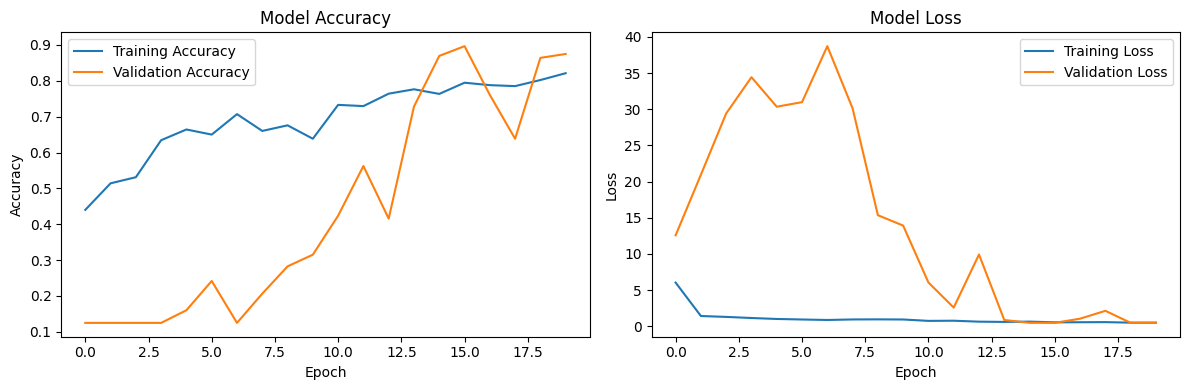

In [43]:
# --- Evaluate the Model ---
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# --- Plot Training History (Optional) ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Results

As can be seen we got a final accuracy of 0.87 which is pretty good. It looked like our model loss was just about flattening out when the model finished training which makes me pretty confident in these results. The accuracy graph is a bit more sparattic. I think our learning rate might have been a bit high. I think maybe doing a learning rate of 0.0005 and 50 epochs could result in a slightly better model but the training time would be a lot higher.

### GAN sound generator

I was curious if using random sounds we could create a GAN model that would be able to generate spectrograms that are similar to the dataset.

In [70]:
X_spectrograms = np.array(all_spectrograms)

# Normalize spectrograms to [-1, 1] for GANs (especially with tanh output in generator)
X_normalized = (X_spectrograms - np.min(X_spectrograms)) / (np.max(X_spectrograms) - np.min(X_spectrograms))
X_normalized = (X_normalized * 2) - 1 # Scale to [-1, 1]


In [44]:
# Hyper parameters
# GAN specific parameters
LATENT_DIM = 100    # Dimension of the latent space (noise vector) for the generator
BATCH_SIZE = 32     # Batch size for GAN training
EPOCHS = 100        # Number of epochs for GAN training (GANs often need more)
GENERATOR_LR = 0.0002 # Learning rate for the generator
DISCRIMINATOR_LR = 0.0002 # Learning rate for the discriminator
BETA_1 = 0.5        # Beta1 for Adam optimizer (common for GANs)

Found 8 classes: ['Airplane', 'Bics', 'Cars', 'Helicopter', 'Motocycles', 'Train', 'Truck', 'bus']
Processing 673 files for class: Airplane
Processing 617 files for class: Bics
Processing 230 files for class: Cars
Processing 353 files for class: Helicopter
Processing 537 files for class: Motocycles
Processing 2552 files for class: Train
Processing 265 files for class: Truck
Processing 4221 files for class: bus

Finished processing. Total spectrograms: 1840
Example spectrogram shape: (128, 130, 1)


C:\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                     │ (None, 131072)              │      13,238,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_142              │ (None, 131072)              │         524,288 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_157 (LeakyReLU)          │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_24 (Reshape)                 │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_69                  │ (None, 32, 32, 256)         │       2,097,408 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_143              │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_158 (LeakyReLU)          │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_70                  │ (None, 64, 64, 128)         │         524,416 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_144              │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_159 (LeakyReLU)          │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_71                  │ (None, 128, 128, 64)        │         131,136 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_145              │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_160 (LeakyReLU)          │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_92 (Conv2D)                   │ (None, 128, 128, 1)         │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,518,913 (63.01 MB)

 Trainable params: 16,255,873 (62.01 MB)

 Non-trainable params: 263,040 (1.00 MB)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_93 (Conv2D)                   │ (None, 64, 65, 64)          │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_161 (LeakyReLU)          │ (None, 64, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_94 (Conv2D)                   │ (None, 32, 33, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_146              │ (None, 32, 33, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_162 (LeakyReLU)          │ (None, 32, 33, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 16, 17, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_147              │ (None, 16, 17, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_163 (LeakyReLU)          │ (None, 16, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_28 (Flatten)                 │ (None, 69632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 1)                   │          69,633 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 728,001 (2.78 MB)

 Trainable params: 727,233 (2.77 MB)

 Non-trainable params: 768 (3.00 KB)

Model: "gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ generator (Sequential)               │ (None, 128, 128, 1)         │      16,518,913 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resize_output (Lambda)               │ (None, 128, 130, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ discriminator (Sequential)           │ (None, 1)                   │         728,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,246,914 (65.79 MB)

 Trainable params: 16,255,873 (62.01 MB)

 Non-trainable params: 991,041 (3.78 MB)


Starting GAN training...

Epoch 1/20


C:\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Batch 0/28 - D Loss: 0.6948, D Accuracy: 0.0000 - G Loss: 0.6874

Epoch 2/20
Batch 0/28 - D Loss: 0.6996, D Accuracy: 0.0000 - G Loss: 0.5497

Epoch 3/20
Batch 0/28 - D Loss: 0.7072, D Accuracy: 0.0000 - G Loss: 0.4860

Epoch 4/20
Batch 0/28 - D Loss: 0.7282, D Accuracy: 0.0000 - G Loss: 0.4119

Epoch 5/20
Batch 0/28 - D Loss: 0.7595, D Accuracy: 0.0000 - G Loss: 0.3492

Epoch 6/20
Batch 0/28 - D Loss: 0.8028, D Accuracy: 0.0000 - G Loss: 0.3032

Epoch 7/20
Batch 0/28 - D Loss: 0.8620, D Accuracy: 0.0000 - G Loss: 0.2667

Epoch 8/20
Batch 0/28 - D Loss: 0.9341, D Accuracy: 0.0000 - G Loss: 0.2382

Epoch 9/20
Batch 0/28 - D Loss: 1.0134, D Accuracy: 0.0000 - G Loss: 0.2156

Epoch 10/20
Batch 0/28 - D Loss: 1.0934, D Accuracy: 0.0000 - G Loss: 0.1968
Epoch 10 completed. D Loss: 1.1668, D Accuracy: 0.0000, G Loss: 0.1817


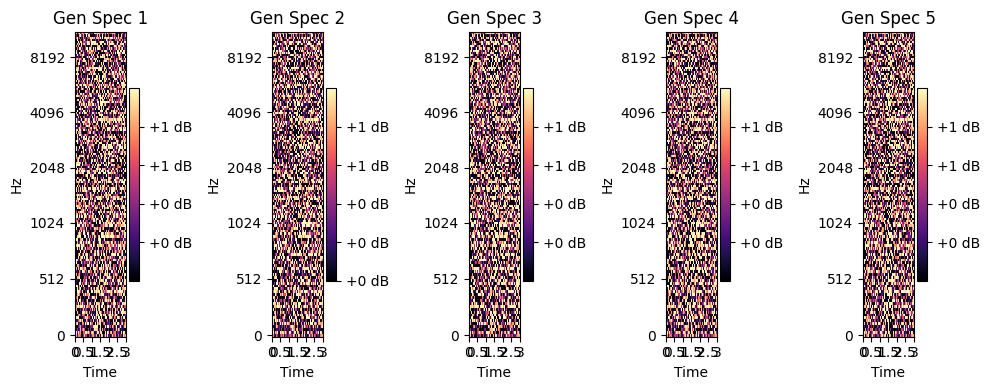


Epoch 11/20
Batch 0/28 - D Loss: 1.1695, D Accuracy: 0.0000 - G Loss: 0.1812

Epoch 12/20
Batch 0/28 - D Loss: 1.2397, D Accuracy: 0.0000 - G Loss: 0.1680

Epoch 13/20
Batch 0/28 - D Loss: 1.3038, D Accuracy: 0.0000 - G Loss: 0.1568

Epoch 14/20
Batch 0/28 - D Loss: 1.3618, D Accuracy: 0.0000 - G Loss: 0.1471

Epoch 15/20
Batch 0/28 - D Loss: 1.4141, D Accuracy: 0.0000 - G Loss: 0.1386

Epoch 16/20
Batch 0/28 - D Loss: 1.4614, D Accuracy: 0.0000 - G Loss: 0.1312

Epoch 17/20
Batch 0/28 - D Loss: 1.5043, D Accuracy: 0.0000 - G Loss: 0.1246

Epoch 18/20
Batch 0/28 - D Loss: 1.5432, D Accuracy: 0.0000 - G Loss: 0.1188

Epoch 19/20
Batch 0/28 - D Loss: 1.5788, D Accuracy: 0.0000 - G Loss: 0.1135

Epoch 20/20
Batch 0/28 - D Loss: 1.6113, D Accuracy: 0.0000 - G Loss: 0.1087
Epoch 20 completed. D Loss: 1.6403, D Accuracy: 0.0000, G Loss: 0.1046


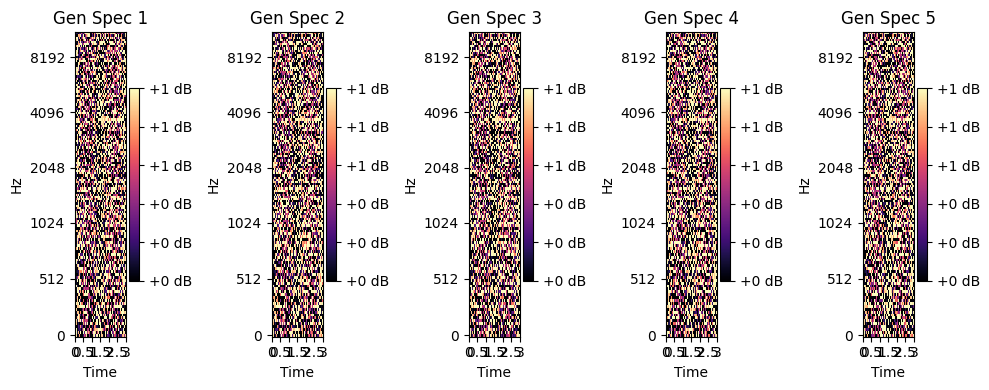


GAN training complete.


In [96]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- Configuration ---
# Set the base path where your audio data is located
# Adjust this path to where your "Devin_Riess_Deep_Learning_Final/Data" folder is
base_data_path = "Devin_Riess_Deep_Learning_Final\\Data" # Example: "/path/to/your/Devin_Riess_Deep_Learning_Final/Data"

# Parameters for Mel spectrograms
SR = 22050          # Standard sample rate for audio (samples per second)
N_FFT = 2048        # Number of samples per FFT window
HOP_LENGTH = 512    # Number of samples between successive frames
N_MELS = 128        # Number of Mel bands to generate (height of the spectrogram image)
DURATION_SEC = 3    # Target duration for each audio clip (in seconds)
MAX_AUDIO_SAMPLES = SR * DURATION_SEC # Max number of samples per audio clip
FILE_NUM_CAP = 230  # Cap the number of files per class

# GAN specific parameters
LATENT_DIM = 100    # Dimension of the latent space (noise vector) for the generator
BATCH_SIZE = 64     # Batch size for GAN training
EPOCHS = 20        # Number of epochs for GAN training (GANs often need more)
GENERATOR_LR = 0.0002 # Learning rate for the generator
DISCRIMINATOR_LR = 0.0002 # Learning rate for the discriminator
BETA_1 = 0.5        # Beta1 for Adam optimizer (common for GANs)

# --- Data Ingestion and Mel Spectrogram Creation ---
all_spectrograms = []
all_labels = []

# Get the list of subdirectories (which are your class labels)
class_labels = sorted([d for d in os.listdir(base_data_path) if os.path.isdir(os.path.join(base_data_path, d))])

print(f"Found {len(class_labels)} classes: {class_labels}")

for label in class_labels:
    class_path = os.path.join(base_data_path, label)
    audio_files = [f for f in os.listdir(class_path) if f.endswith('.wav')]
    print(f"Processing {len(audio_files)} files for class: {label}")

    count = 0
    for audio_file in audio_files:
        if count >= FILE_NUM_CAP:
            break # Cap the number of files per class

        file_path = os.path.join(class_path, audio_file)
        
        try:
            # 1. Load the audio file
            y, sr = librosa.load(file_path, sr=SR, duration=DURATION_SEC)

            # Pad or truncate audio to a fixed length
            if len(y) < MAX_AUDIO_SAMPLES:
                y = np.pad(y, (0, MAX_AUDIO_SAMPLES - len(y)), 'constant')
            elif len(y) > MAX_AUDIO_SAMPLES:
                y = y[:MAX_AUDIO_SAMPLES]

            if len(y) != MAX_AUDIO_SAMPLES:
                 print(f"Warning: Audio for {audio_file} has unexpected length {len(y)}. Expected {MAX_AUDIO_SAMPLES}.")
                 continue

            # 2. Compute the Mel spectrogram
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)

            # 3. Convert to Decibels (log scale)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            # Important: Ensure consistent shape for all spectrograms
            target_frames = int(np.ceil(MAX_AUDIO_SAMPLES / HOP_LENGTH))
            
            if mel_spec_db.shape[1] < target_frames:
                pad_width = target_frames - mel_spec_db.shape[1]
                mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant', constant_values=np.min(mel_spec_db))
            elif mel_spec_db.shape[1] > target_frames:
                mel_spec_db = mel_spec_db[:, :target_frames]

            # Add a channel dimension for Conv2D (e.g., (n_mels, time_frames, 1))
            mel_spec_db = mel_spec_db[..., np.newaxis]

            all_spectrograms.append(mel_spec_db)
            all_labels.append(label) # Keep labels for potential conditional GAN or just for reference
            count += 1

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue

print(f"\nFinished processing. Total spectrograms: {len(all_spectrograms)}")
if all_spectrograms:
    print(f"Example spectrogram shape: {all_spectrograms[0].shape}")
    SPECTROGRAM_SHAPE = all_spectrograms[0].shape
else:
    SPECTROGRAM_SHAPE = (N_MELS, target_frames, 1) # Fallback if no data processed
    print("Warning: No spectrograms processed. Using default SPECTROGRAM_SHAPE.")

# Convert lists to numpy arrays and explicitly cast to float32
X_spectrograms = np.array(all_spectrograms, dtype=np.float32)

# Normalize spectrograms to [-1, 1] for GANs (especially with tanh output in generator)
X_normalized = (X_spectrograms - np.min(X_spectrograms)) / (np.max(X_spectrograms) - np.min(X_spectrograms))
X_normalized = (X_normalized * 2) - 1 # Scale to [-1, 1]

# Optional: Encode labels if you plan for a Conditional GAN later
le = LabelEncoder()
y_encoded = le.fit_transform(all_labels)
num_classes = len(le.classes_)
# For unconditional GAN, we don't directly use y_one_hot in training,
# but it's here for completeness if you decide to extend.
y_one_hot = tf.keras.utils.to_categorical(y_encoded, num_classes=num_classes)

# --- Define the Generator ---
# Calculate initial dense layer output shape for reshaping
initial_height = SPECTROGRAM_SHAPE[0] // (2**3)
initial_width = SPECTROGRAM_SHAPE[1] // (2**3) 
initial_height = max(4, initial_height)
initial_width = max(4, initial_width)   
initial_filters = 512

generator = keras.Sequential([
    keras.Input(shape=(LATENT_DIM,), name="generator_input"),
    layers.Dense(initial_height * initial_width * initial_filters),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    layers.Reshape((initial_height, initial_width, initial_filters)),

    layers.Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),

    layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),

    layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    
    # output
    layers.Conv2D(SPECTROGRAM_SHAPE[2], kernel_size=(5, 5), padding='same', activation='tanh')
], name='generator')


# --- Define the Discriminator ---
discriminator = keras.Sequential([
    keras.Input(shape=SPECTROGRAM_SHAPE, name='discriminator_input'),
    layers.Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
], name='discriminator')

generator.summary()
discriminator.summary()

# --- Define the GAN (Combined Model) ---
# For the combined GAN model, the discriminator's weights should not be trainable
# when training the generator.
discriminator.trainable = False

# The GAN takes noise as input and outputs a discriminator prediction
gan_input = keras.Input(shape=(LATENT_DIM,))
fake_spectrogram_raw = generator(gan_input)

# *** FIX: Use a Lambda layer for tf.image.resize in the GAN definition ***
# Removed output_shape argument to allow Keras to infer it more robustly.
fake_spectrogram = layers.Lambda(
    lambda x: tf.image.resize(
        x,
        [SPECTROGRAM_SHAPE[0], SPECTROGRAM_SHAPE[1]],
        method=tf.image.ResizeMethod.BILINEAR,
        preserve_aspect_ratio=False
    ),
    name='resize_output'
)(fake_spectrogram_raw)

gan_output = discriminator(fake_spectrogram)

gan = keras.Model(inputs=gan_input, outputs=gan_output, name="gan")
gan.summary()

# --- Compile Models ---
# Discriminator compilation
d_optimizer = keras.optimizers.Adam(learning_rate=DISCRIMINATOR_LR, beta_1=BETA_1)
discriminator.compile(optimizer=d_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Generator and GAN compilation
g_optimizer = keras.optimizers.Adam(learning_rate=GENERATOR_LR, beta_1=BETA_1)
# For the GAN, we want the generator to trick the discriminator, so labels are all 1 (real)
gan.compile(optimizer=g_optimizer, loss='binary_crossentropy')

# --- GAN Training Loop ---
print("\nStarting GAN training...")

# Prepare real data for training
# Create a TensorFlow Dataset for efficient batching and shuffling
train_dataset = tf.data.Dataset.from_tensor_slices(X_normalized).shuffle(buffer_size=X_normalized.shape[0]).batch(BATCH_SIZE, drop_remainder=True)

# Labels for real and fake images for discriminator training
real_labels = tf.ones((BATCH_SIZE, 1), dtype=tf.float32)
fake_labels = tf.zeros((BATCH_SIZE, 1), dtype=tf.float32)

# Labels for generator training (generator wants discriminator to output 1 for fakes)
misleading_labels = tf.ones((BATCH_SIZE, 1), dtype=tf.float32)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    for i, real_spectrograms in enumerate(train_dataset):
        # --- Train the Discriminator ---
        # Generate fake spectrograms
        noise = tf.random.normal(shape=(BATCH_SIZE, LATENT_DIM), dtype=tf.float32)
        fake_spectrograms_raw = generator(noise)

        # *** FIX: Use tf.image.resize directly in the training loop as it's eager execution ***
        fake_spectrograms = tf.image.resize(
            fake_spectrograms_raw,
            [SPECTROGRAM_SHAPE[0], SPECTROGRAM_SHAPE[1]],
            method=tf.image.ResizeMethod.BILINEAR,
            preserve_aspect_ratio=False
        )

        # Ensure dtypes match just before concatenation and discriminator input
        real_spectrograms = tf.cast(real_spectrograms, tf.float32)
        fake_spectrograms = tf.cast(fake_spectrograms, tf.float32)

        # Combine real and fake spectrograms for discriminator input
        combined_spectrograms = tf.concat([real_spectrograms, fake_spectrograms], axis=0)
        combined_labels = tf.concat([real_labels, fake_labels], axis=0)

        # Add some random noise to discriminator labels (label smoothing)
        combined_labels += 0.05 * tf.random.uniform(tf.shape(combined_labels), dtype=tf.float32)

        # --- DEBUGGING PRINTS (Optional - remove for cleaner output) ---
        # print(f"DEBUG (Discriminator Train): combined_spectrograms shape: {combined_spectrograms.shape}, dtype: {combined_spectrograms.dtype}")
        # print(f"DEBUG (Discriminator Train): discriminator.input_shape: {discriminator.input_shape}")
        # print(f"DEBUG (Discriminator Train): combined_labels shape: {combined_labels.shape}, dtype: {combined_labels.dtype}")
        # --- END DEBUGGING PRINTS ---

        # Train discriminator
        d_loss, d_accuracy = discriminator.train_on_batch(combined_spectrograms, combined_labels)

        # --- Train the Generator ---
        # Generate new noise for generator training
        noise = tf.random.normal(shape=(BATCH_SIZE, LATENT_DIM), dtype=tf.float32)
        
        # Train generator (discriminator weights are frozen here)
        g_loss = gan.train_on_batch(noise, misleading_labels)

        # Print progress
        if i % 50 == 0:
            print(f"Batch {i}/{len(train_dataset)} - D Loss: {d_loss:.4f}, D Accuracy: {d_accuracy:.4f} - G Loss: {g_loss:.4f}")
    
    # Optional: Save generated images at the end of each epoch to visualize progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1} completed. D Loss: {d_loss:.4f}, D Accuracy: {d_accuracy:.4f}, G Loss: {g_loss:.4f}")
        # Generate and display a few example spectrograms
        num_examples = 5
        noise = tf.random.normal(shape=(num_examples, LATENT_DIM), dtype=tf.float32)
        generated_specs_raw = generator(noise).numpy()

        # Resize for visualization too, to match the real spectrogram dimensions
        generated_specs = tf.image.resize(
            generated_specs_raw,
            [SPECTROGRAM_SHAPE[0], SPECTROGRAM_SHAPE[1]],
            method=tf.image.ResizeMethod.BILINEAR,
            preserve_aspect_ratio=False
        ).numpy()

        # Denormalize for plotting (reverse the [-1, 1] scaling)
        generated_specs_denormalized = (generated_specs + 1) / 2
        
        plt.figure(figsize=(num_examples * 2, 4))
        for j in range(num_examples):
            plt.subplot(1, num_examples, j + 1)
            # Remove the channel dimension for plotting
            librosa.display.specshow(generated_specs_denormalized[j, :, :, 0], sr=SR, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Gen Spec {j+1}')
            plt.tight_layout()
        plt.show()

print("\nGAN training complete.")


### Results

First pass:
First pass we did basic settings epoch 10, default adam, batch size 32, and got an accuracy of 0.2477' Second pass we did epochs 10, batch size 4 and increased learning rate to 0.001. The results were quite bad. It had an accuracy of 0.15-0.2 after multiple epochs. I even played around with some hyper parameters but it did not get better. I will loop back and add in the magnitued of the frequencies to make this a 2d problem

Second Pass:
This ended up doing well as well. I ended up tuning some of the hyper parameters. I increased the batch size to 32 and had the learning rate at 0.001. It ended up doing the best out of all of the models and got an accuracy of 0.91 which is impressive.

Third Pass:
This method was great. We ended up swapping to using spec images. It came from the same data files but instead of doing an fft we generated spec images. Using those spec images we could create a deep learning model that used Conv2D and Dense layers and a softmax output to create a more accurate predictor. In this model we ended up getting a model that had around 0.8 accuracy.

### Gan model:

The gan model was not working properly on the first pass. the accuracy started at 0 and ended at 0. I think part of the reason is that the weights were not avaialable for training. Its still cool to see the spectral images that were generated. Although they look like complete noise not soud waves. I will say that the data that was used for the training itself was also pretty poor. The spec images that are shown in the data analysis protion do not look like anything of substance either. I think thats why the training for all of the models was poor

## Conclusion

There was a lot going on in this final project. I ended up creating 3 different models here in an attempt to solve the problem I set out to solve. The first two were focused around the classification of the sound data and the thrid one was the generative visualization of the sound data. 

Talking about the first model. It struggled with the data. I tried initiall with a 1d input on just the frequency and that resulted in poor accuracy around 0.15. I then upgraded this model to use 2d inputs and had a combination of frequency and magnitudes. I expected the model to be much better on this since I gave it a whole new dimension of data to train on. This was the case and I ended up with my best predictive model in this fassion. Getting it up to around 0.9 accuracy. 

The second model that I made was predicting of off images themselves. I created a spectrogram from 3 second .wav files and used the data from those images to train a new model. I thought this might be helpful since CNN are pretty good at classifying images as well. I ended up getting to around 0.87 with that model which is also a pretty good place to be. I think both of these models performed similarly since they were using the same data and the spectrogram is really just a visual representation of the fft.

Finally, I set out to create a GAN of some sort and ended up going with image generation on the spectrograms. This was similar to the process in week 5 and I used the spectrograms I had created in the second model as my input set. I had to use random noise for the discriminator since I did not have a mapping of any sort. This ended up being terrible at creating images. THe colors are accurate in the sense that it uses the same color pallete as a spectrogram but the pixels are just noise still. I think this is becuase I used all of the wav files and not just a subset of the wave files. However, I still thought this was interesting to see.